In [119]:
import os
import numpy as np
import time
import tensorflow as tf
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

my_seed = 23753
np.random.seed(my_seed)
tf.random.set_seed(my_seed)

In [120]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# To use fashion_mnist uncomment the next two lines.
# from keras.datasets import fashion_mnist
# (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [121]:
# normalize x
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))
print('Train dimension:');print(X_train.shape)
print('Test dimension:');print(X_test.shape)

Train dimension:
(60000, 784)
Test dimension:
(10000, 784)


In [122]:
from sklearn import preprocessing
# Define the One-hot Encoder
ohe = preprocessing.OneHotEncoder()
# Reshape data
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Fit and transform training data
ohe.fit(y_train)
y_train = ohe.transform(y_train).toarray()

# Fit and transform testing data
ohe.fit(y_test)
y_test = ohe.transform(y_test).toarray()

print('Train labels dimension:');print(y_train.shape)
print('Test labels dimension:');print(y_test.shape)

Train labels dimension:
(60000, 10)
Test labels dimension:
(10000, 10)


In [123]:
size_input = 784
size_hidden1 = 512
size_hidden2 = 256
size_output = 10

In [124]:
# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [125]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden1, size_hidden2, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of hidden layer 1
    size_hidden2: int, size of hidden layer 2
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_output, device
    
    # # Initialize weights between input layer and hidden layer
    # self.W0 = tf.Variable(tf.random.normal([self.size_input, self.size_input_layer]))
    # # Initialize biases for hidden layer
    # self.b0 = tf.Variable(tf.random.normal([1, self.size_input_layer]))

    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden1]))

    # Initialize weights between hidden layer and output layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden2]))

    # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))

    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]

  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    #y_pred_tf = tf.cast(tf.reshape(y_pred, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy()
    loss = cce(y_true_tf, y_pred_tf)
    l2_penalty = 0.001 * ((tf.reduce_sum(tf.square(self.W1)) + tf.reduce_sum(tf.square(self.W2)) + tf.reduce_sum(tf.square(self.W3)))/3)
    #Uncomment to add L2 Penalty
    #return loss + l2_penalty
    return loss

  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=6e-2)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    keep_prob = 0.3
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    
    # # Compute values in input layer
    # what0 = tf.matmul(X_tf, self.W0) + self.b0
    # hhat0 = tf.nn.relu(what0)
    # hhat00 = tf.nn.dropout(hhat0, keep_prob)

    # Compute values in hidden layer 1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    #Uncomment to add dropout
    #hhat11 = tf.nn.dropout(hhat1, keep_prob)
    hhat11 = hhat1

    # Compute values in hidden layer 2
    what2 = tf.matmul(hhat11, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    #Uncomment to add dropout
    #hhat22 = tf.nn.dropout(hhat2, keep_prob)
    hhat22 = hhat2

    # Compute output
    output = tf.matmul(hhat22, self.W3) + self.b3
    op = tf.nn.softmax(output)

    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return op

  def accuracy(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(tf.reshape(y_pred, (-1, self.size_output)), dtype=tf.float32)
    correct_pred = tf.equal(tf.argmax(y_true, 1), tf.argmax(y_pred, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    return accuracy

In [126]:
# Set number of epochs
NUM_EPOCHS = 30

In [127]:
mlp = MLP(size_input, size_hidden1, size_hidden2, size_output, device='gpu')
time_start = time.time()
loss_list = []
acc_list = []
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc = 0
  count = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(32, seed=epoch*(my_seed)).batch(600)
  for inputs, outputs in train_ds:
    preds = mlp.forward(inputs)
    loss_total = loss_total + mlp.loss(preds, outputs)
    lt = lt + mlp.loss(preds, outputs)
    mlp.backward(inputs, outputs)
    acc = acc + mlp.accuracy(preds, outputs)
    count += 1

  loss_list.append(np.sum(loss_total * 100) / X_train.shape[0])
  acc_list.append(acc/count*100)
  print('Number of Epoch = {} - Average loss:= {} - Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / X_train.shape[0], acc/count))
time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
# For per epoch_time = Total_Time / Number_of_epochs



Number of Epoch = 1 - Average loss:= 0.3166638671875 - Accuracy:= 0.25358328223228455
Number of Epoch = 2 - Average loss:= 0.3108456380208333 - Accuracy:= 0.38259994983673096
Number of Epoch = 3 - Average loss:= 0.30740009765625 - Accuracy:= 0.42386671900749207
Number of Epoch = 4 - Average loss:= 0.30408190104166666 - Accuracy:= 0.4607832431793213
Number of Epoch = 5 - Average loss:= 0.2998575846354167 - Accuracy:= 0.5325832962989807
Number of Epoch = 6 - Average loss:= 0.2961735026041667 - Accuracy:= 0.5846498608589172
Number of Epoch = 7 - Average loss:= 0.29300641276041667 - Accuracy:= 0.6183501482009888
Number of Epoch = 8 - Average loss:= 0.29051422526041665 - Accuracy:= 0.6276001334190369
Number of Epoch = 9 - Average loss:= 0.287590234375 - Accuracy:= 0.6532666087150574
Number of Epoch = 10 - Average loss:= 0.28512145182291665 - Accuracy:= 0.6630833148956299
Number of Epoch = 11 - Average loss:= 0.28214560546875 - Accuracy:= 0.6921166777610779
Number of Epoch = 12 - Average los

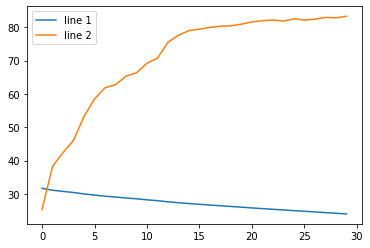

In [128]:
# plot lines
plt.plot(loss_list, label = "line 1")
plt.plot(acc_list, label = "line 2")
plt.legend()
plt.show()

In [130]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
#test_loss_total = 0.0
acc, n = 0, 0
for inputs, outputs in test_ds:
  preds = mlp.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp.loss(preds, outputs)
  acc = acc + mlp.accuracy(preds, outputs)
  n+=1
  
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_train.shape[0]))
print(acc/n)

Test loss: 0.7474
tf.Tensor(0.83666134, shape=(), dtype=float32)
